ALSA lib ../../../src/pcm/pcm_direct.c:2049:(snd1_pcm_direct_parse_open_conf) The field ipc_gid must be a valid group (create group audio)
ALSA lib ../../../src/pcm/pcm_direct.c:2049:(snd1_pcm_direct_parse_open_conf) The field ipc_gid must be a valid group (create group audio)
ALSA lib ../../../src/pcm/pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib ../../../src/pcm/pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib ../../../src/pcm/pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib ../../oss/pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib ../../oss/pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib ../../src/confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib ../../usb_stream/pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib ../../src/confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib ../../usb_stream/pcm_usb_stream.c:482

running
done


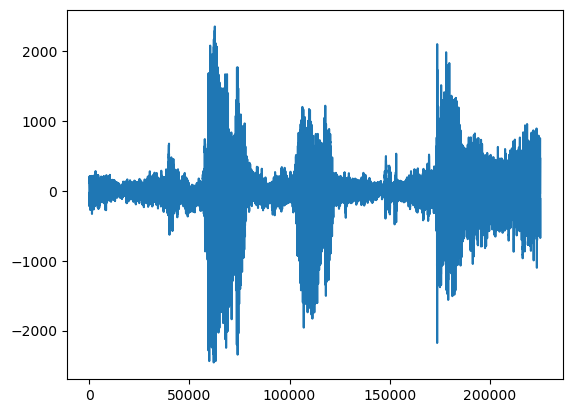

In [8]:
import pyaudio
import numpy
import matplotlib.pyplot as plt
FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220
p = pyaudio.PyAudio()
print("running")
stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,
input=True,frames_per_buffer=FRAMESIZE)
data = stream.read(NOFFRAMES*FRAMESIZE)
decoded = numpy.frombuffer(data,dtype=numpy.int16);
stream.stop_stream()
stream.close()
p.terminate()
print("done")
numpy.save(decoded)
plt.plot(decoded)
plt.show()